# Lab 9: Correlation & Regression

In [41]:
# Run this cell to set up the notebook, but please don't change it.
import numpy as np
from datascience import *

# These lines set up the plotting functionality and formatting.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# 1. The Dataset

In this lab, we are exploring movie screenplays. In particular, we have compiled a list of 5,000 words (including stemmed words) that occur in conversations between movie characters. For each movie, our dataset tells us the frequency with which each of these words occurs in certain conversations in its screenplay. All words have been converted to lowercase.

Run the cell below to read the `movies` table.

In [42]:
movies = Table.read_table('movies.csv')
movies.where("Title", "wild wild west").select(0, 1, 2, 3, 4, 14, 49, 1042, 4004)

Title,Year,Rating,Genre,# Words,breez,england,it,bravo
wild wild west,1999,4.3,comedy,3446,0,0,0.0212635,0


The above cell prints a few columns of the row for the comedy movie *Wild Wild West*.  The movie contains 3446 words. The word "it" appears 74 times, as it makes up  $\frac{74}{3446} \approx 0.021364$ of the words in the movie. The word "england" doesn't appear at all.
This numerical representation of a body of text, one that describes only the frequencies of individual words, is called a bag-of-words representation. A lot of information is discarded in this representation: the order of the words, the context of each word, who said what, the cast of characters and actors, etc. However, a bag-of-words representation is often used for machine learning applications as a reasonable starting point, because a great deal of information is also retained and expressed in a convenient and compact format.

All movie titles are unique. The `row_for_title` function provides fast access to the one row for each title. 

*Note: All movies in our dataset have their titles lower-cased.* 

In [43]:
title_index = movies.index_by('Title')
def row_for_title(title):
    """Return the row for a title, similar to the following expression (but faster)
    
    movies.where('Title', title).row(0)
    """
    return title_index.get(title)[0]

For example, the fastest way to find the frequency of "none" in the movie *The Terminator* is to access the `'none'` item from its row. Check the original table to see if this worked for you!

In [44]:
row_for_title('the terminator').item('none') 

0.0009633911368015

#### Question 1.1
Set `expected_row_sum` to the number that you __expect__ will result from summing all proportions in each row, excluding the first five columns.

<!--
BEGIN QUESTION
name: q1_1
-->

In [45]:
# Set row_sum to a number that's the (approximate) sum of each row of word proportions.
expected_row_sum = 1

This dataset was extracted from [a dataset from Cornell University](http://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html). After transforming the dataset (e.g., converting the words to lowercase, removing the naughty words, and converting the counts to frequencies), we created this new dataset containing the frequency of 5000 common words in each movie.

## 2. Word Stemming
The columns other than "Title", "Year", "Rating", "Genre", and "# Words" in the `movies` table are all words that appear in some of the movies in our dataset.  These words have been *stemmed*, or abbreviated heuristically, in an attempt to make different [inflected](https://en.wikipedia.org/wiki/Inflection) forms of the same base word into the same string.  For example, the column "manag" is the sum of proportions of the words "manage", "manager", "managed", and "managerial" (and perhaps others) in each movie. This is a common technique used in machine learning and natural language processing.

Stemming makes it a little tricky to search for the words you want to use, so we have provided another table that will let you see examples of unstemmed versions of each stemmed word.  Run the code below to load it.

In [46]:
# Just run this cell.
vocab_mapping = Table.read_table('stem.csv')
stemmed = np.take(movies.labels, np.arange(3, len(movies.labels)))
vocab_table = Table().with_column('Stem', stemmed).join('Stem', vocab_mapping)
vocab_table.take(np.arange(1100, 1110))

Stem,Word
bond,bonding
bone,bone
bone,boning
bone,bones
bonu,bonus
book,bookings
book,books
book,booking
book,booked
book,book


#### Question 2.1
Assign `stemmed_message` to the stemmed version of the word "vegetable".

<!--
BEGIN QUESTION
name: q2_1
-->

In [47]:
stemmed_message = vocab_table.where("Word", are.equal_to("vegetable")).column(0).item(0)
stemmed_message

'veget'

#### Question 2.2
What stem in the dataset has the most words that are shortened to it? Assign `most_stem` to that stem.

<!--
BEGIN QUESTION
name: q2_2
-->

In [48]:
most_stem = vocab_table.group("Stem")
most_first = most_stem.where('count', are.equal_to(max(most_stem.column(1))))
most_second = most_first.column(0).item(0)
most_stem

Stem,count
a,1
ab,2
abandon,2
abduct,3
abil,2
abl,1
aboard,1
abort,4
about,1
abov,1


#### Question 2.3
What is the longest word in the dataset whose stem wasn't shortened? Assign that to `longest_uncut`. Break ties alphabetically from Z to A (so if your options are "albatross" or "batman", you should pick "batman").

<!--
BEGIN QUESTION
name: q2_3
-->

In [55]:
# In our solution, we found it useful to first add columns with
# the length of the word and the length of the stem,
# and then to add a column with the difference between those lengths.
# What will the difference be if the word is not shortened?
word_lenghts = make_array()
for i in range(vocab_table.num_rows):
    word_lenghts = np.append(word_lenghts, len(vocab_table.column("Word").item(1)))

the_stem = make_array()
for i in range(vocab_table.num_rows):
    the_stem = np.append(the_stem, len(vocab_table.column("Stem").item(1)))


tbl_with_lens = vocab_table.with_column("Word lenghts", word_lenghts)
tbl_with_dif = tbl_with_lens.with_column("Difference", word_lenghts - the_stem)


longest_uncut = tbl_with_dif.where("Difference", are.equal_to(0)).sort("Word lenghts", descending = True).column('Stem').item(1)
longest_uncut

'ab'

## 3. Relationships Between Pairs of Words

For this section we will look at the relationship between the proportion of the word `her` in screenplays versus the word `she`. We would like to use linear regression to make predictions about this relationship, but that won't work well if the data aren't roughly linearly related. To check that, we should look at the data. Run the cell below to construct a new table `she_her` that contains only the proportions of the words `she` and `her` in the screenplays.

In [7]:
she_her = movies.select("she", "her")
she_her

she,her
0.0061667,0.00676348
0.00929316,0.00450577
0.00224593,0.000748643
0.00330797,0.00198478
0.0010981,0.00146413
0,0.0016129
0.00207727,0
0.00388469,0.00163566
0.00283661,0.00189107
0.0068835,0.00361384


**Question 3.1.** Make a scatter plot of the data.  It's conventional to put the column we want to predict on the vertical axis and the other column on the horizontal axis. Lets's say we want to use the proportions of `she` to predict the proportions of `her`

<!--
BEGIN QUESTION
name: q3_1
-->

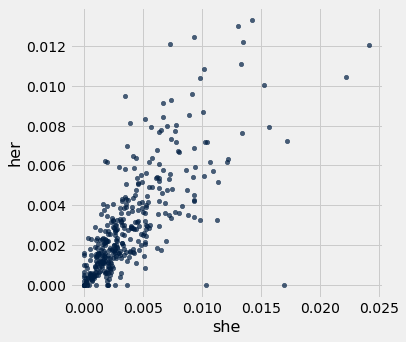

In [8]:
she_her.scatter("she", "her")

**Question 3.2.** Are the proportions of `she` and `her` in the screenplays roughly linearly related based on the scatter plot above?

<!--
BEGIN QUESTION
name: q3_2
-->

Yes it seems to be positvely linear

We're going to continue with the assumption that they are linearly related, so it's reasonable to use linear regression to analyze this data.

We'd next like to plot the data in standard units. If you don't remember the definition of standard units, textbook section [14.2](https://www.inferentialthinking.com/chapters/14/2/Variability.html#standard-units) might help!

**Question 3.3.** Compute the mean and standard deviation for the proportions of `she` and `her` in the screenplays.  **Then** create a table called `she_her_standard` containing the proportions of `she` and `her` in the screenplays in standard units.  The columns should be named `she (standard units)` and `her (standard units)`.

<!--
BEGIN QUESTION
name: q2_3
-->

In [9]:
she_mean = np.mean(she_her.column("she"))
she_std = np.std(she_her.column("she"))
her_mean = np.mean(she_her.column("her"))
her_std = np.std(she_her.column("her"))

she_her_standard = Table().with_columns(
    "she (standard units)", (she_her.column("she") - she_mean)/she_std,
    "her (standard units)", (she_her.column("her") - her_mean)/her_std
)

she_her_standard

she (standard units),her (standard units)
0.64874,1.41556
1.54528,0.555731
-0.475576,-0.875146
-0.171026,-0.40437
-0.804727,-0.602658
-1.11962,-0.545998
-0.523939,-1.16026
-0.00564772,-0.537332
-0.306193,-0.440059
0.854288,0.216043


**Question 3.4.** Plot the data again, but this time in standard units.

<!--
BEGIN QUESTION
name: q3_4
-->

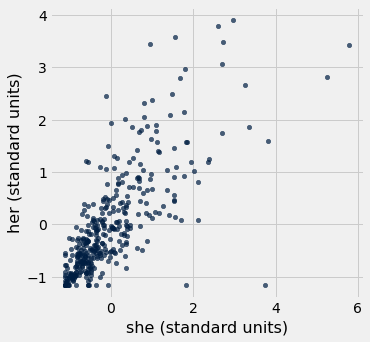

In [10]:
she_her_standard.scatter("she (standard units)", "her (standard units)")

You'll notice that this plot looks the same as the last one!  However, the data and axes are scaled differently.  So it's important to read the ticks on the axes.

**Question 3.5.** Which would you guess best describes the correlation between the proportions of `she` and `her` in this dataset?

1. correlation is positive (but not close to zero)
2. correlation is close to zero
3. correlation is negative (but not close to zero)

Assign `correlation` to the number corresponding to your guess.

<!--
BEGIN QUESTION
name: q2_5
-->

In [11]:
correlation = 1

**Question 3.6.** Compute the correlation `r`.  

*Hint:* Use `she_her_standard`.  Section [15.1](https://www.inferentialthinking.com/chapters/15/1/Correlation.html#calculating-r) explains how to do this.


<!--
BEGIN QUESTION
name: q2_6
-->

In [12]:
r = np.average(she_her_standard.column("her (standard units)") * she_her_standard.column("she (standard units)"))
r

0.74953528976920514

## 3. The Regression Line
Correlation is the **slope of the regression line when the data are put in standard units**.

The next cell plots the regression line in standard units:

$$\text{her proportion in standard units} = r \times \text{she proportions in standard units}.$$

Then, it plots the data in standard units again, for comparison.

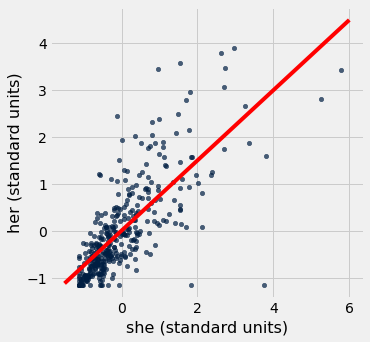

In [13]:
def draw_line(slope=0, intercept=0, x=make_array(-1.5, 6), color='r'):
    y = x*slope + intercept
    plots.plot(x, y, color=color)

she_her_standard.scatter('she (standard units)', 'her (standard units)')
draw_line(slope = r)

How would you take a point in standard units and convert it back to original units?  We'd have to "stretch" its horizontal position by `she_std` and its vertical position by `her_std`. That means the same thing would happen to the slope of the line.

Stretching a line horizontally makes it less steep, so we divide the slope by the stretching factor.  Stretching a line vertically makes it more steep, so we multiply the slope by the stretching factor.

**Question 3.1.** Calculate the slope of the regression line in original units, and assign it to `slope`.

(If the "stretching" explanation is unintuitive, consult section [15.2](https://www.inferentialthinking.com/chapters/15/2/Regression_Line.html#the-equation-of-the-regression-line) in the textbook.)

<!--
BEGIN QUESTION
name: q3_1
-->

In [14]:
slope = r * her_std/she_std
slope

0.56436875787214202

We know that the regression line passes through the point `(she_mean, her_mean)`.  You might recall from high-school algebra that the equation for the line is therefore:

$$\text{her proportion} - \verb|her_mean| = \texttt{slope} \times (\text{she proportion} - \verb|she_mean|)$$

The rearranged equation becomes:

$$\text{her proportion} = \texttt{slope} \times \text{she proportion} + (- \texttt{slope} \times \verb|she_mean| + \verb|her_mean|)$$


**Question 3.2.** Calculate the intercept in original units and assign it to `intercept`.

<!--
BEGIN QUESTION
name: q3_2
-->

In [15]:
intercept = her_mean - (slope * she_mean)
intercept

0.00084304898014150647

Below you should see a plot of the data in original units as well as the regression line. This plot should look the same as the one plotted at the begining of this section, but with different values on the axes.

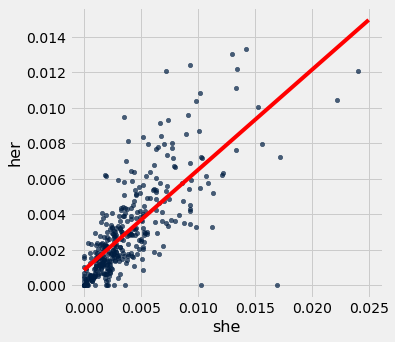

In [16]:
she_her.scatter('she', 'her')
draw_line(slope = slope, intercept = intercept,  x = make_array(0,0.025))

You are done with Lab 9!